In [1]:
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score

2024-06-07 05:15:14.689783: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 05:15:14.689979: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 05:15:14.692231: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 05:15:14.722258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 05:15:15.276796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
seed(123)

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [3]:
train_set = pd.read_csv('adult/adult.data', sep=", ", header=None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ", skiprows=1, header=None, engine='python')

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
              'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Szybki preprocessing

In [4]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

/tmp/ipykernel_596129/4187203541.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})
/tmp/ipykernel_596129/4187203541.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['native_country'] = dataset['native_country'].replace(d)


Stadardyzacja

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(f"X_train shape:\t{X_train.shape}")
print(f"X_test shape:\t{X_test.shape}")

X_train shape:	(30162, 41)
X_test shape:	(15060, 41)


# SGD

In [6]:
history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-07 05:15:17.754640: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

In [ ]:
history_sgd.history.keys()

In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [ ]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_lr_1])


In [ ]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

In [8]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate

In [9]:
optimizer_configs = [
    {"name": "Adam 0.001", "learning_rate": 0.001, "use_scheduler": False},
    {"name": "Adam 0.001 with scheduler", "learning_rate": 0.001, "use_scheduler": True},
    {"name": "Adam 0.0001 with scheduler", "learning_rate": 0.0001, "use_scheduler": True},
]

In [10]:
models_history_name = []

for config in optimizer_configs:
    optimizer = keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model = Sequential()
    model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
    model.add(Dense(50,activation="sigmoid"))
    model.add(Dense(10,activation="sigmoid"))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    callbacks = []
    if config["use_scheduler"]:
        callbacks.append(LearningRateScheduler(step_decay))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30,
                        verbose=0, callbacks=callbacks)
    models_history_name.append((history, model, config["name"]))
    print(f"finished {config['name']}")

/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/krystianjachna/Desktop/AI/.venv/lib/python3.11/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


finished Adam 0.001
finished Adam 0.001 with scheduler
finished Adam 0.0001 with scheduler


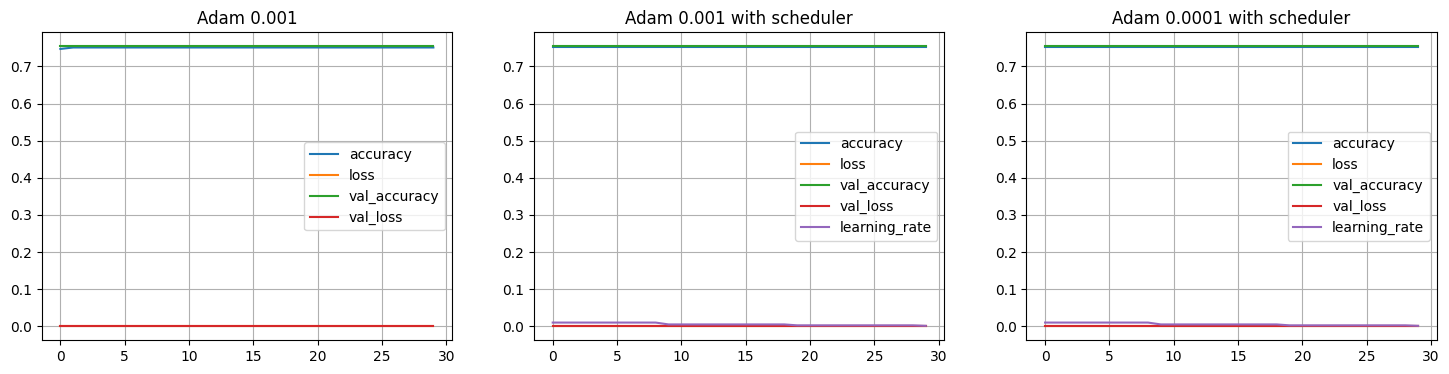

In [14]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))

axs = axs.flatten()

for i, (history, model, name) in enumerate(models_history_name):
    pd.DataFrame(history.history).plot(ax=axs[i])
    axs[i].set_title(name)
    axs[i].grid(True)
    axs[i].legend()

In [12]:
df = pd.DataFrame(columns=["config", "accuracy"])

for i, (history, model, name) in enumerate(models_history_name):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    df.loc[i] = [name, accuracy]

df

471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


,config,accuracy
0,Adam 0.001,0.754316
1,Adam 0.001 with scheduler,0.754316
2,Adam 0.0001 with scheduler,0.754316


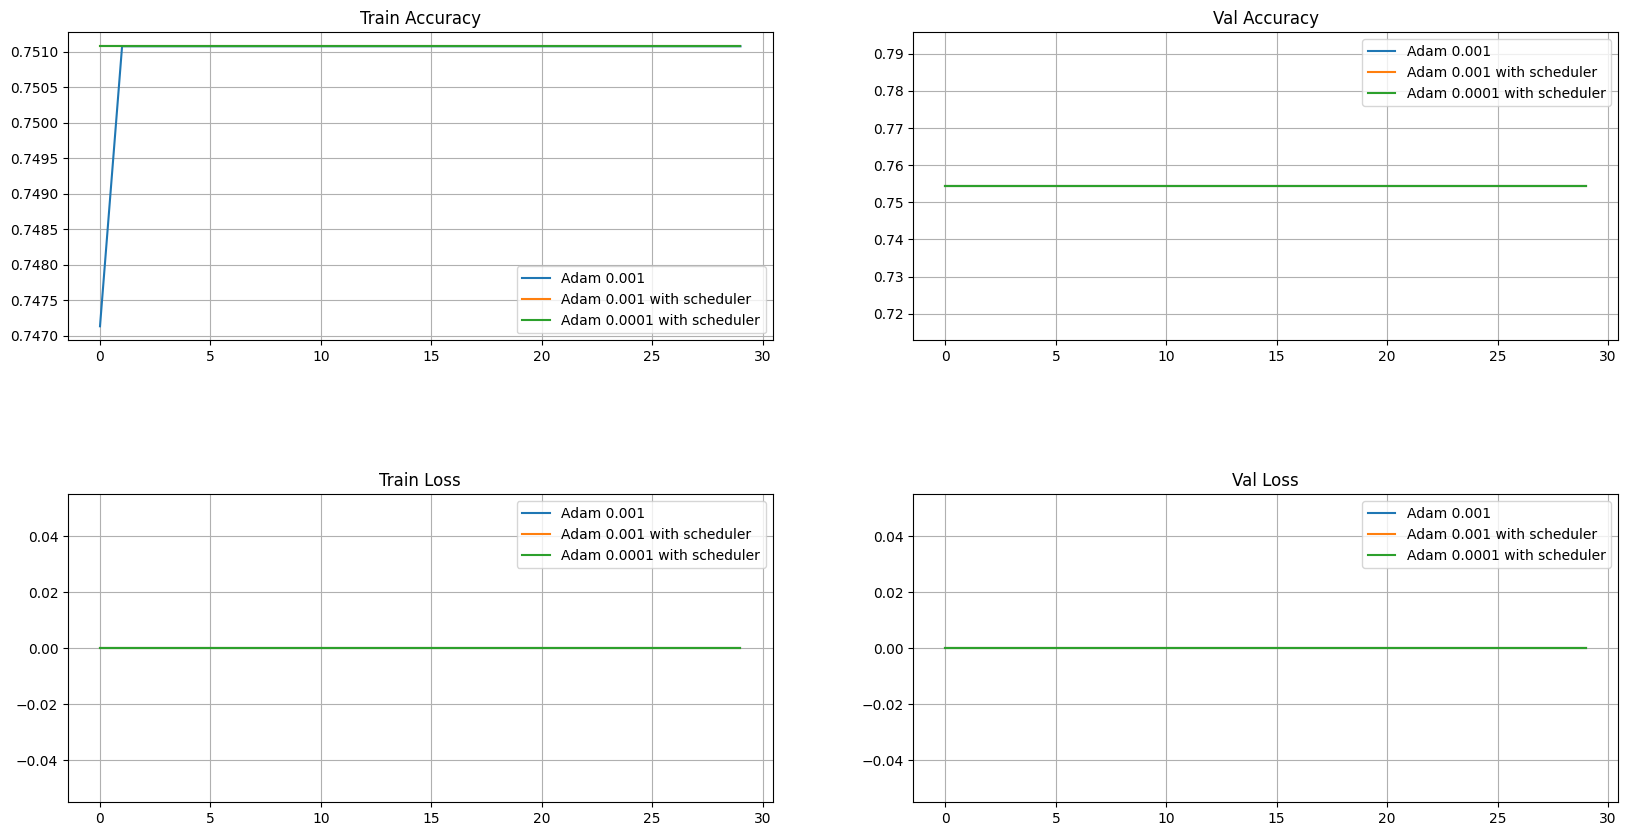

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

for i, (history, _, name) in enumerate(models_history_name):
    axs[0][0].plot(history.history['accuracy'], label=f'{name}')
    axs[0][1].plot(history.history['val_accuracy'], label=f'{name}')
    axs[1][0].plot(history.history['loss'], label=f'{name}')
    axs[1][1].plot(history.history['val_loss'], label=f'{name}')

axs[0][0].set_title('Train Accuracy')
axs[0][1].set_title('Val Accuracy')
axs[1][0].set_title('Train Loss')
axs[1][1].set_title('Val Loss')

for ax in axs.flatten():
    ax.legend()
    ax.grid(True)

plt.subplots_adjust(hspace=0.5)
plt.show()